Sessions counted: 114
Total number o cells: 43747
Mean GOOD cells per session: 383.75
Std  GOOD cells per session: 138.35


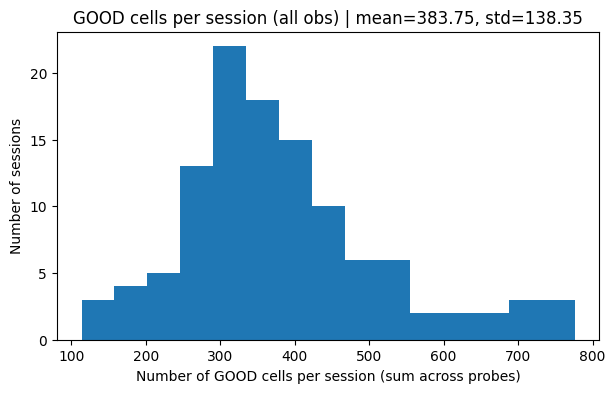

In [ ]:
from __future__ import annotations

import re
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests

# ============================= USER SETTINGS =============================
dt_folder = Path(r"J:\project_trainingAggression\Data")

Agg = ["975826", "975827", "975833", "978772", "988590", "1010820", "1010823", "1010826", "1029741"]
nonAgg = ["975830", "978774", "978775", "1010819", "997839", "997840", "997841", "1029736", "1029739", "1032216"] # 978775 mounts/light attacks on the last day of training
maladaptive = ["978513", "978527", "978528", "1010832", "1013590"]
all_mice = set(Agg + nonAgg + maladaptive)

OBS_ALLOWED = {f"obs{i}" for i in range(1, 7)}   # obs1..obs6
LABELS_GOOD = {"good"}                           # what "good" means in TSV


# ============================= HELPERS ==================================
def find_mouse_id(path: Path, ids: set[str]) -> str | None:
    s = str(path)
    for mid in ids:
        if re.search(rf"(?<!\d){re.escape(mid)}(?!\d)", s):
            return mid
    return None


def find_obs_id(path: Path) -> str | None:
    m = re.search(r"(?i)(obs[1-6])", str(path))
    return m.group(1).lower() if m else None


def load_good_cluster_ids_from_auto(auto_dir: Path, good_labels=LABELS_GOOD) -> np.ndarray:
    """
    Reads GOOD clusters from either cluster_group.tsv or cluster_info.tsv inside autoForNeuroConcat.
    Prefers cluster_group.tsv if present.
    """
    cg = auto_dir / "cluster_group.tsv"
    ci = auto_dir / "cluster_info.tsv"

    if cg.exists():
        df = pd.read_csv(cg, sep="\t")
        if "cluster_id" in df.columns and "group" in df.columns:
            grp = df["group"].astype("string").str.strip().str.lower()
            good = df.loc[grp.isin(good_labels), "cluster_id"].to_numpy(np.int64)
            return np.unique(good)

    if ci.exists():
        df = pd.read_csv(ci, sep="\t")
        # common patterns
        if "cluster_id" in df.columns and "group" in df.columns:
            grp = df["group"].astype("string").str.strip().str.lower()
            good = df.loc[grp.isin(good_labels), "cluster_id"].to_numpy(np.int64)
            return np.unique(good)

    return np.array([], dtype=np.int64)


def session_key_from_auto_dir(auto_dir: Path) -> str:
    """
    Make a readable session key from the path:
    catgt_YYYYMMDD_mXXXX_obsY_gZ  (the catgt folder name) + probe/imec if present.
    """
    s = str(auto_dir)
    m = re.search(r"(catgt_[^\\\/]+)", s)
    catgt = m.group(1) if m else auto_dir.parent.name
    # probe label if available
    if "imec0" in s.lower():
        probe = "imec0"
    elif "imec1" in s.lower():
        probe = "imec1"
    elif "imec2" in s.lower():
        probe = "imec2"
    else:
        probe = "imec?"
    return f"{catgt}_{probe}"


# ============================= DISCOVER & COUNT ==========================
# Use autoForNeuroConcat as the anchor (avoids duplicates like sorter_output)
auto_dirs = [p for p in dt_folder.rglob("autoForNeuroConcat") if p.is_dir()]
auto_dirs = sorted(auto_dirs)

# Count GOOD units per *session* by summing probes (imec0/1/2)
# Session identity = the catgt folder (catgt_..._obsX_gY)
session_counts = defaultdict(int)
session_meta = {}  # key -> dict(mouse, obs)

for auto_dir in auto_dirs:
    mid = find_mouse_id(auto_dir, all_mice)
    if mid is None:
        continue

    obs = find_obs_id(auto_dir)
    if obs is None or obs not in OBS_ALLOWED:
        continue

    good_ids = load_good_cluster_ids_from_auto(auto_dir)
    n_good = int(good_ids.size)
    if n_good == 0:
        continue

    # collapse probes into the parent catgt session
    # find the catgt_* folder in the path
    m = re.search(r"(catgt_[^\\\/]+)", str(auto_dir))
    catgt_name = m.group(1) if m else auto_dir.parent.name  # fallback

    session_counts[catgt_name] += n_good
    session_meta.setdefault(catgt_name, {"mouse": mid, "obs": obs})

# Convert to array
counts = np.array(list(session_counts.values()), dtype=np.int64)

if counts.size == 0:
    raise RuntimeError("No GOOD units found. Check path, obs filters, and TSV labels.")

mean_cells = float(counts.mean())
std_cells = float(counts.std(ddof=1)) if counts.size > 1 else 0.0

print(f"Sessions counted: {counts.size}")
print(f"Total number of cells: {sum(counts)}")
print(f"Mean GOOD cells per session: {mean_cells:.2f}")
print(f"Std  GOOD cells per session: {std_cells:.2f}")

# ============================= PLOT HISTOGRAM =============================
plt.figure(figsize=(7, 4))
plt.hist(counts, bins=15)
plt.xlabel("Number of GOOD cells per session (sum across probes)")
plt.ylabel("Number of sessions")
plt.title(f"GOOD cells per session (all obs) | mean={mean_cells:.2f}, std={std_cells:.2f}")
plt.show()


Probe-sessions counted: 342
Mean GOOD cells per probe-session: 127.92
Std  GOOD cells per probe-session: 75.96


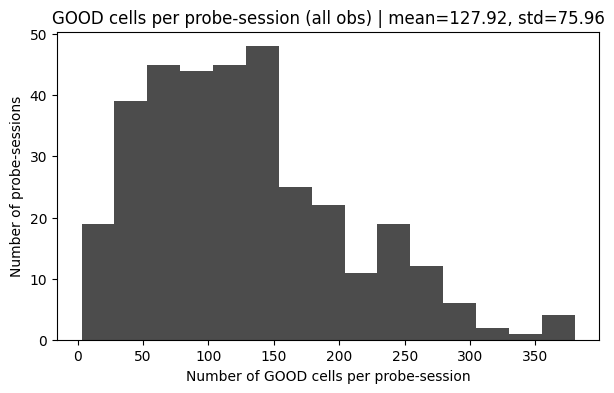

imec0: n=114, mean=92.05, std=71.63


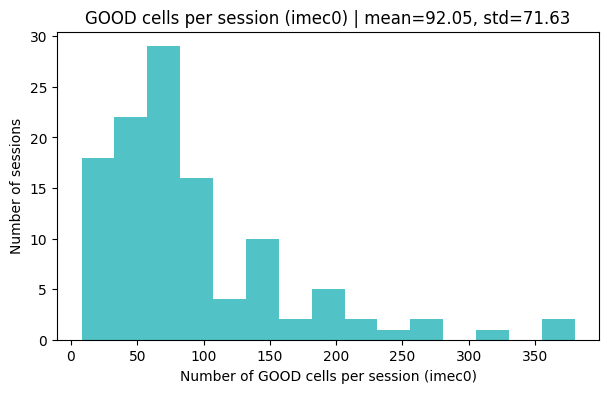

imec1: n=114, mean=144.67, std=85.13


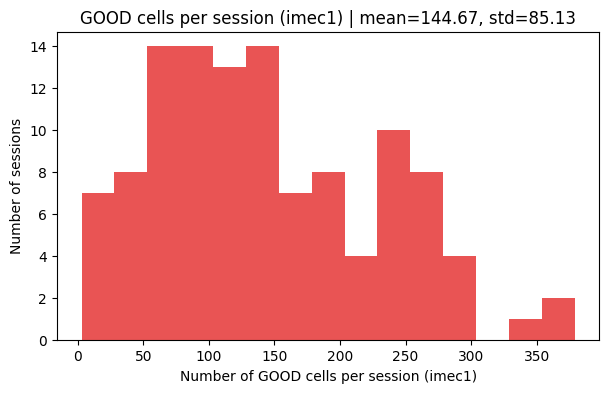

imec2: n=114, mean=147.03, std=55.56


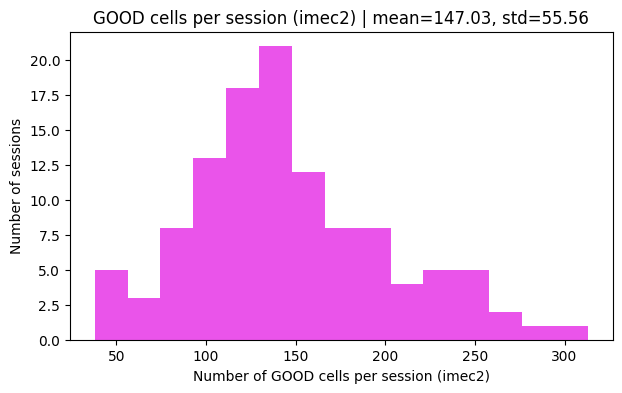

In [13]:
# ============================= DISCOVER & COUNT (PER PROBE) ==============
# Use autoForNeuroConcat as the anchor (avoids duplicates like sorter_output)
auto_dirs = [p for p in dt_folder.rglob("autoForNeuroConcat") if p.is_dir()]
auto_dirs = sorted(auto_dirs)

def probe_label_from_path(p: Path) -> str:
    s = str(p).lower()
    m = re.search(r"(imec\d)", s)
    return m.group(1) if m else "imec?"

# Count GOOD units per *probe* (imec0/1/2) per session
# Key identity = (catgt_..._obsX_gY) + probe label
probe_session_counts = defaultdict(int)
probe_session_meta = {}  # key -> dict(mouse, obs, probe, catgt)

for auto_dir in auto_dirs:
    mid = find_mouse_id(auto_dir, all_mice)
    if mid is None:
        continue

    obs = find_obs_id(auto_dir)
    if obs is None or obs not in OBS_ALLOWED:
        continue

    good_ids = load_good_cluster_ids_from_auto(auto_dir)
    n_good = int(good_ids.size)
    if n_good == 0:
        continue

    # find the catgt_* folder in the path
    m = re.search(r"(catgt_[^\\\/]+)", str(auto_dir))
    catgt_name = m.group(1) if m else auto_dir.parent.name  # fallback

    probe = probe_label_from_path(auto_dir)

    key = f"{catgt_name}_{probe}"
    probe_session_counts[key] += n_good  # usually just one dir per key, but += is safe
    probe_session_meta.setdefault(key, {"mouse": mid, "obs": obs, "probe": probe, "catgt": catgt_name})

# Convert to array
counts = np.array(list(probe_session_counts.values()), dtype=np.int64)

if counts.size == 0:
    raise RuntimeError("No GOOD units found. Check path, obs filters, and TSV labels.")

mean_cells = float(counts.mean())
std_cells = float(counts.std(ddof=1)) if counts.size > 1 else 0.0

print(f"Probe-sessions counted: {counts.size}")
print(f"Mean GOOD cells per probe-session: {mean_cells:.2f}")
print(f"Std  GOOD cells per probe-session: {std_cells:.2f}")

# ============================= PLOT HISTOGRAM (ALL PROBES TOGETHER) ======
plt.figure(figsize=(7, 4))
plt.hist(counts, bins=15, color = "black", alpha = 0.7)
plt.xlabel("Number of GOOD cells per probe-session")
plt.ylabel("Number of probe-sessions")
plt.title(f"GOOD cells per probe-session (all obs) | mean={mean_cells:.2f}, std={std_cells:.2f}")
plt.show()

# ============================= OPTIONAL: HISTOGRAM PER PROBE (SEPARATE) ==
# If you want separate distributions for imec0 vs imec1 vs imec2:
by_probe = defaultdict(list)
for k, v in probe_session_counts.items():
    prb = probe_session_meta[k]["probe"]
    by_probe[prb].append(v)

colors = ["#07a8ad","#e00b0b","#e20ce2"]

for it, prb in enumerate(sorted(by_probe.keys())):
    arr = np.array(by_probe[prb], dtype=np.int64)
    mu = float(arr.mean()) if arr.size else np.nan
    sd = float(arr.std(ddof=1)) if arr.size > 1 else 0.0
    print(f"{prb}: n={arr.size}, mean={mu:.2f}, std={sd:.2f}")

    plt.figure(figsize=(7, 4))
    plt.hist(arr, bins=15, color = colors[it], alpha = 0.7)
    plt.xlabel(f"Number of GOOD cells per session ({prb})")
    plt.ylabel("Number of sessions")
    plt.title(f"GOOD cells per session ({prb}) | mean={mu:.2f}, std={sd:.2f}")
    plt.show()


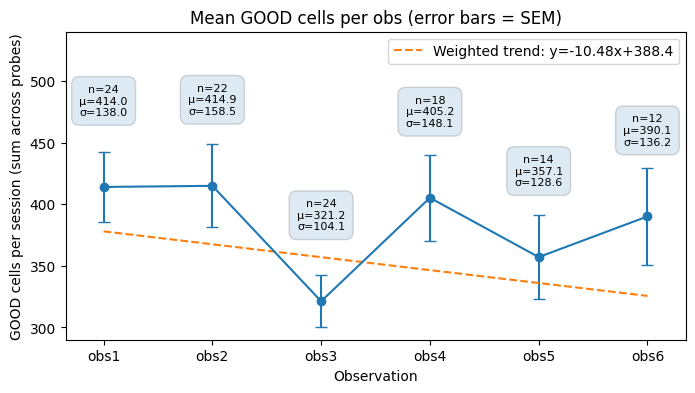

In [6]:
# ============================= MEAN GOOD CELLS PER OBS (ERROR BARS) =============================
obs_order = [f"obs{i}" for i in range(1, 7)]

# collect session-level counts by obs
obs_vals = {obs: [] for obs in obs_order}
for catgt_name, n_good in session_counts.items():
    obs = session_meta.get(catgt_name, {}).get("obs", None)
    if obs in obs_vals:
        obs_vals[obs].append(n_good)

means, sds, sems, ns = [], [], [], []
for obs in obs_order:
    v = np.array(obs_vals[obs], dtype=float)
    ns.append(int(v.size))
    if v.size == 0:
        means.append(np.nan)
        sds.append(np.nan)
        sems.append(np.nan)
    else:
        mu = float(v.mean())
        sd = float(v.std(ddof=1)) if v.size > 1 else 0.0
        sem = sd / np.sqrt(v.size) if v.size > 1 else 0.0
        means.append(mu)
        sds.append(sd)
        sems.append(sem)

x = np.arange(1, 7)

# choose error type here: SD or SEM
use_sem = True
yerr = sems if use_sem else sds
err_label = "SEM" if use_sem else "SD"

fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(x, means, yerr=yerr, fmt="-o", capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(obs_order)
ax.set_xlabel("Observation")
ax.set_ylabel("GOOD cells per session (sum across probes)")
ax.set_title(f"Mean GOOD cells per obs (error bars = {err_label})")
ax.set_ylim([290, 540])

# Put annotations slightly ABOVE each point, with a fixed pixel offset
for xi, mu, sd, n in zip(x, means, sds, ns):
    if not np.isfinite(mu):
        ax.annotate("n=0", (xi, 0), textcoords="offset points", xytext=(0, 8),
                    ha="center", va="bottom", fontsize=8)
        continue

    txt = f"n={n}\nμ={mu:.1f}\nσ={sd:.1f}"
    ax.annotate(
        txt,
        (xi, mu),
        textcoords="offset points",
        xytext=(0, 50),   # 10 points above the marker
        ha="center",
        va="bottom",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.7", alpha=0.15)  # optional, makes it readable
    )

# ---- Trend line (linear fit weighted by SEM) ----
means_arr = np.array(means, dtype=float)
sems_arr  = np.array(sems, dtype=float)
x_arr     = x.astype(float)

mask = np.isfinite(means_arr) & np.isfinite(sems_arr) & (sems_arr > 0)

w = 1.0 / (sems_arr[mask] ** 2)
coef_w = np.polyfit(x_arr[mask], means_arr[mask], 1, w=w)

trend = np.polyval(coef_w, x_arr)  # <-- evaluate on x (obs 1..6)

ax.plot(x_arr, trend, "--", linewidth=1.5,
        label=f"Weighted trend: y={coef_w[0]:.2f}x+{coef_w[1]:.1f}")
ax.legend()

ax.margins(x=0.07, y=0.25) 
plt.show()

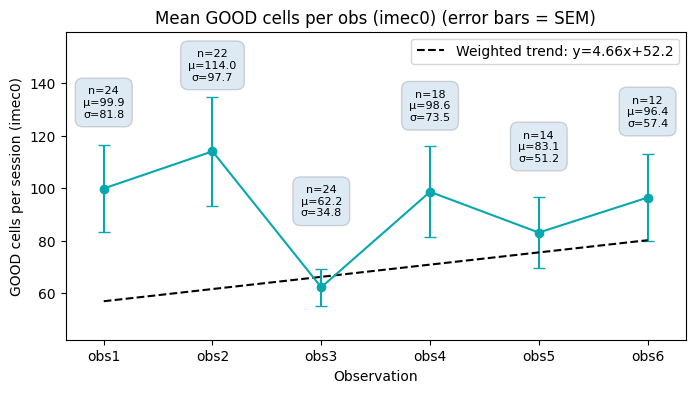

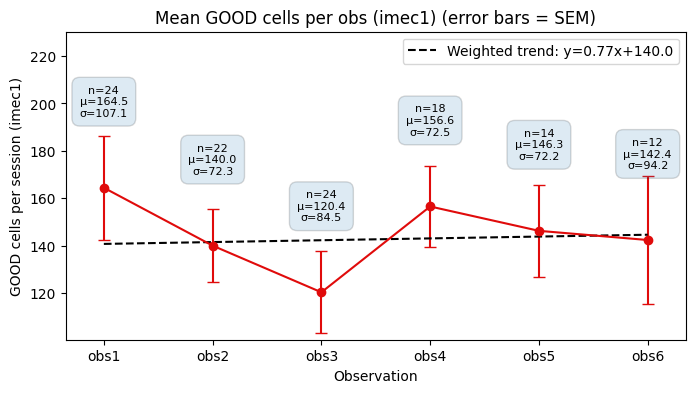

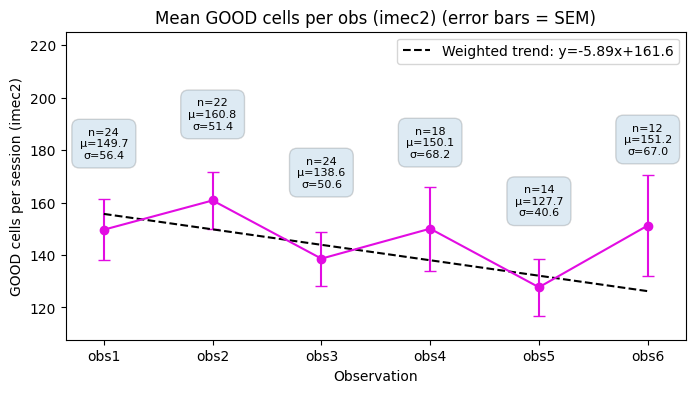

In [7]:
# ============================= MEAN GOOD CELLS PER OBS (ERROR BARS) PER PROBE =============================
obs_order = [f"obs{i}" for i in range(1, 7)]
x = np.arange(1, 7)

# choose error type here: SD or SEM
use_sem = True
err_label = "SEM" if use_sem else "SD"

# Group values by probe, then by obs
probe_obs_vals = defaultdict(lambda: {obs: [] for obs in obs_order})

for key, n_good in probe_session_counts.items():
    meta = probe_session_meta.get(key, {})
    obs = meta.get("obs", None)
    probe = meta.get("probe", None)
    if probe is None or obs not in OBS_ALLOWED:
        continue
    if obs in probe_obs_vals[probe]:
        probe_obs_vals[probe][obs].append(n_good)

# Plot one figure per probe
for it, probe in enumerate(sorted(probe_obs_vals.keys())):
    obs_vals = probe_obs_vals[probe]

    means, sds, sems, ns = [], [], [], []
    for obs in obs_order:
        v = np.array(obs_vals[obs], dtype=float)
        ns.append(int(v.size))
        if v.size == 0:
            means.append(np.nan)
            sds.append(np.nan)
            sems.append(np.nan)
        else:
            mu = float(v.mean())
            sd = float(v.std(ddof=1)) if v.size > 1 else 0.0
            sem = sd / np.sqrt(v.size) if v.size > 1 else 0.0
            means.append(mu)
            sds.append(sd)
            sems.append(sem)

    yerr = sems if use_sem else sds

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.errorbar(x, means, yerr=yerr, fmt="-o", capsize=4, color = colors[it])
    ax.set_xticks(x)
    ax.set_xticklabels(obs_order)
    ax.set_xlabel("Observation")
    ax.set_ylabel(f"GOOD cells per session ({probe})")
    ax.set_title(f"Mean GOOD cells per obs ({probe}) (error bars = {err_label})")
    ax.set_ylim([min(means)-20, max(means)*1.4])

    # (Optional) probe-specific y-limits.
    # If you want the same y-limits as before, uncomment the next line:

    # ---- Annotations ----
    for xi, mu, sd, n in zip(x, means, sds, ns):
        if not np.isfinite(mu):
            ax.annotate("n=0", (xi, 0), textcoords="offset points", xytext=(0, 8),
                        ha="center", va="bottom", fontsize=8)
            continue

        txt = f"n={n}\nμ={mu:.1f}\nσ={sd:.1f}"
        ax.annotate(
            txt,
            (xi, mu),
            textcoords="offset points",
            xytext=(0, 50),
            ha="center",
            va="bottom",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.7", alpha=0.15)
        )

    # ---- Trend line (linear fit weighted by SEM) ----
    means_arr = np.array(means, dtype=float)
    sems_arr  = np.array(sems, dtype=float)
    x_arr     = x.astype(float)

    mask = np.isfinite(means_arr) & np.isfinite(sems_arr) & (sems_arr > 0)
    if mask.sum() >= 2:
        w = 1.0 / (sems_arr[mask] ** 2)
        coef_w = np.polyfit(x_arr[mask], means_arr[mask], 1, w=w)
        trend = np.polyval(coef_w, x_arr)
        ax.plot(x_arr, trend, "--", linewidth=1.5,
                label=f"Weighted trend: y={coef_w[0]:.2f}x+{coef_w[1]:.1f}", color ='k')
        ax.legend()

    ax.margins(x=0.07, y=0.25)
    plt.show()

Rows: 114 | mice: 24 | obs present: ['obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6']
Categories (6, object): ['obs1' < 'obs2' < 'obs3' < 'obs4' < 'obs5' < 'obs6']

Mouse-aware ANOVA (Type II):
                sum_sq    df         F    PR(>F)
C(mouse)  8.406004e+05  23.0  2.663480  0.000592
C(obs)    1.642222e+05   5.0  2.393589  0.044154
Residual  1.166356e+06  85.0       NaN       NaN

Omnibus test for obs effect (accounting for mouse): p = 0.04415

Mouse-aware pairwise obs contrasts (Holm corrected):
obs2 vs obs3: p=0.00632, p_holm=0.0948, sig=False
obs1 vs obs3: p=0.0074, p_holm=0.104, sig=False
obs3 vs obs4: p=0.0225, p_holm=0.293, sig=False
obs3 vs obs6: p=0.0797, p_holm=0.957, sig=False
obs1 vs obs2: p=0.895, p_holm=1, sig=False
obs1 vs obs4: p=0.875, p_holm=1, sig=False
obs1 vs obs5: p=0.171, p_holm=1, sig=False
obs1 vs obs6: p=0.71, p_holm=1, sig=False
obs2 vs obs4: p=0.786, p_holm=1, sig=False
obs2 vs obs5: p=0.146, p_holm=1, sig=False
obs2 vs obs6: p=0.639, p_holm=1, sig=Fals

C:\Users\Data Analysis\AppData\Local\Temp\ipykernel_10484\221565817.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=obs_order, showfliers=False)


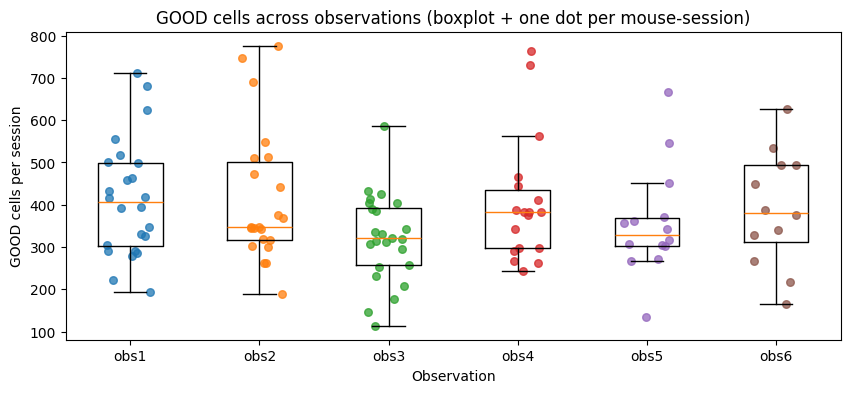

In [8]:
# -----------------------
# Build long-form dataframe: 1 row per session
# -----------------------
rows = []
for catgt_name, n_good in session_counts.items():
    meta = session_meta.get(catgt_name, {})
    mid = meta.get("mouse", None)
    obs = meta.get("obs", None)
    if mid is None or obs is None:
        continue
    rows.append({"session": catgt_name, "mouse": str(mid), "obs": str(obs), "n_good": float(n_good)})

df = pd.DataFrame(rows).dropna()
obs_order = [f"obs{i}" for i in range(1, 7)]
df["obs"] = pd.Categorical(df["obs"], categories=obs_order, ordered=True)

print("Rows:", len(df), "| mice:", df["mouse"].nunique(), "| obs present:", df["obs"].dropna().unique())

# -----------------------
# Mouse-aware ANOVA (mouse as blocking factor)
# n_good ~ mouse + obs
# -----------------------
model = smf.ols("n_good ~ C(mouse) + C(obs)", data=df).fit()

# Type II ANOVA is a good default here
anova_tbl = anova_lm(model, typ=2)
print("\nMouse-aware ANOVA (Type II):")
print(anova_tbl)

# Omnibus p-value for observation effect:
p_obs = anova_tbl.loc["C(obs)", "PR(>F)"] if "C(obs)" in anova_tbl.index else np.nan
print(f"\nOmnibus test for obs effect (accounting for mouse): p = {p_obs:.4g}")

# -----------------------
# Optional: mouse-aware pairwise obs contrasts (Holm corrected)
# Uses the fitted model to test differences between obs levels while controlling for mouse.
# -----------------------
do_pairwise = True
if do_pairwise:
    # Only compare obs levels that actually exist in data
    present_obs = [o for o in obs_order if (df["obs"] == o).any()]
    pairs = []
    pvals = []

    for i in range(len(present_obs)):
        for j in range(i + 1, len(present_obs)):
            a, b = present_obs[i], present_obs[j]
            # H0: mean(obs=a) == mean(obs=b) in the model
            # In Patsy/statsmodels, the reference level is handled internally; easiest is t_test with explicit contrast.
            # We can get the design matrix column names and build a contrast vector.
            cn = model.model.exog_names

            # Columns look like: Intercept, C(mouse)[T.xxx], C(obs)[T.obs2], ...
            # The base obs level is the first category (obs1) unless missing.
            v = np.zeros(len(cn), dtype=float)

            def col(name):
                return cn.index(name) if name in cn else None

            # effect of obs level is represented as indicator columns vs baseline
            # So obs=a minus obs=b:
            # If a is baseline => coef 0; else coef of C(obs)[T.a]
            # same for b, subtract.
            ca = f"C(obs)[T.{a}]"
            cb = f"C(obs)[T.{b}]"

            ia = col(ca)
            ib = col(cb)
            if ia is not None:
                v[ia] += 1.0
            # baseline has no column
            if ib is not None:
                v[ib] -= 1.0

            test = model.t_test(v)
            p = float(test.pvalue)
            pairs.append((a, b))
            pvals.append(p)

    pvals = np.array(pvals, dtype=float)
    rej, p_holm, _, _ = multipletests(pvals, method="holm")

    out = sorted(zip(pairs, pvals, p_holm, rej), key=lambda x: x[2])
    print("\nMouse-aware pairwise obs contrasts (Holm corrected):")
    for (a, b), p, ph, r in out:
        print(f"{a} vs {b}: p={p:.3g}, p_holm={ph:.3g}, sig={bool(r)}")

# -----------------------
# Plot: box + session dots + per-mouse lines (mouse-aware view)
# -----------------------
fig, ax = plt.subplots(figsize=(10, 4))

data = [df.loc[df["obs"] == o, "n_good"].values for o in obs_order]
ax.boxplot(data, labels=obs_order, showfliers=False)

rng = np.random.default_rng(0)
for i, o in enumerate(obs_order, start=1):
    y = df.loc[df["obs"] == o, "n_good"].to_numpy(float)
    if y.size == 0:
        continue
    xj = i + rng.uniform(-0.18, 0.18, size=y.size)
    ax.scatter(xj, y, s=30, alpha=0.75)

ax.set_xlabel("Observation")
ax.set_ylabel("GOOD cells per session")
ax.set_title("GOOD cells across observations (boxplot + one dot per mouse-session)")
plt.show()


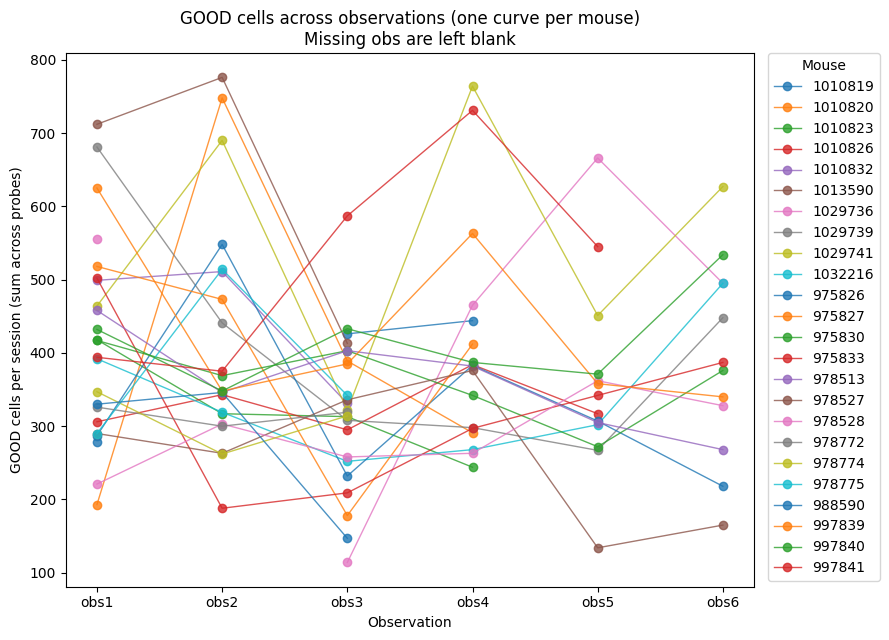

In [18]:
# ============================= ONE CURVE PER MOUSE (GOOD CELLS vs OBS) =============================
obs_order = [f"obs{i}" for i in range(1, 7)]
obs_to_idx = {obs: i for i, obs in enumerate(obs_order)}

# mouse_obs_counts[mid][obs] = total GOOD cells summed across probes for that obs
mouse_obs_counts = {mid: {obs: 0 for obs in obs_order} for mid in sorted(all_mice)}
mouse_obs_has = {mid: {obs: False for obs in obs_order} for mid in sorted(all_mice)}

# We want to avoid double-counting duplicated catgt folders across wrong top-level mouse dirs.
# Dedup key: (mid, catgt_name, obs, probe)
seen_probe = set()

for auto_dir in auto_dirs:
    mid = find_mouse_id(auto_dir, all_mice)
    if mid is None:
        continue

    obs = find_obs_id(auto_dir)
    if obs is None or obs not in OBS_ALLOWED:
        continue

    # identify catgt session name
    m = re.search(r"(catgt_[^\\\/]+)", str(auto_dir))
    catgt_name = m.group(1) if m else auto_dir.parent.name

    # probe
    s = str(auto_dir).lower()
    if "imec0" in s:
        probe = "imec0"
    elif "imec1" in s:
        probe = "imec1"
    elif "imec2" in s:
        probe = "imec2"
    else:
        probe = "imec?"

    key = (mid, catgt_name, obs, probe)
    if key in seen_probe:
        continue
    seen_probe.add(key)

    good_ids = load_good_cluster_ids_from_auto(auto_dir)
    n_good = int(good_ids.size)
    if n_good == 0:
        continue

    mouse_obs_counts[mid][obs] += n_good
    mouse_obs_has[mid][obs] = True

# Convert to a matrix for plotting
x = np.arange(1, 7)

plt.figure(figsize=(9, 6.5))
for mid in sorted(all_mice):
    y = []
    for obs in obs_order:
        # plot NaN for missing obs so the line breaks
        y.append(mouse_obs_counts[mid][obs] if mouse_obs_has[mid][obs] else np.nan)
    y = np.array(y, dtype=float)

    if np.all(np.isnan(y)):
        continue

    plt.plot(x, y, marker="o", linewidth=1, alpha=0.8, label=mid)

plt.xticks(x, obs_order)
plt.xlabel("Observation")
plt.ylabel("GOOD cells per session (sum across probes)")
plt.title("GOOD cells across observations (one curve per mouse)\nMissing obs are left blank")
plt.legend(title="Mouse", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
plt.show()
